In [7]:
# How many rows are there in tx?

import pandas as pd
tx = pd.read_csv("../data/processed/transactions_canonical.csv")

len(tx)

290345

In [8]:
# Number of unique users
tx["shopUserId"].nunique()


64932

In [ ]:
# Bring in the 'status' and 'groupId' columns from articles_clean and merge them into tx
a = pd.read_csv("../data/processed/articles_clean.csv", dtype="string", usecols=["sku", "status", "groupId"])
tx["sku"], a["sku"] = tx["sku"].str.strip(), a["sku"].str.strip()
# Merge status and groupId from articles into tx based on sku
tx = tx.merge(a[["sku", "status", "groupId"]], on="sku", how="left")

# Calculate unique skus and groupIds in tx and articles
tx_sku = pd.Index(tx["sku"].dropna().unique())
a_sku = pd.Index(a["sku"].dropna().unique())
tx_groupid = pd.Index(tx["groupId"].dropna().unique())
a_groupid = pd.Index(a["groupId"].dropna().unique())

# Calculate percentages
sku_pct = 100 * len(tx_sku.intersection(a_sku)) / len(a_sku) if len(a_sku) > 0 else float('nan')
groupid_pct = 100 * len(tx_groupid.intersection(a_groupid)) / len(a_groupid) if len(a_groupid) > 0 else float('nan')

print(f"Unique SKUs in tx: {len(tx_sku):,} | in articles: {len(a_sku):,}")
print(f"SKUs in tx as % of articles: {sku_pct:.2f}%")
print(f"Unique groupIds in tx: {len(tx_groupid):,} | in articles: {len(a_groupid):,}")
print(f"groupIds in tx as % of articles: {groupid_pct:.2f}%")

KeyError: 'groupId'

In [12]:
# Remove rows from tx where sku is not found in articles
tx = tx[tx["sku"].isin(a_sku)]

In [13]:
tx.sort_values("orderId", key=lambda x: x.astype(int)).head()

,orderId,shopUserId,created,currencyId,orderLineId,sku,quantity,price,name,status,groupId
259660,158790,78135,2024-05-22 12:38:29,50,454306.0,291294,1.0,11.3,Vasaravarpaan oikaisija 4/pak,active,291294
259659,158791,78136,2024-05-22 12:44:01,40,454308.0,542092,1.0,89.0,Tvättlappar enfärgade av frotté 5-pack,active,542087
259657,158800,78145,2024-05-22 12:54:51,40,454358.0,250209-0039,1.0,259.0,Hälsotoffel,inactive,250209
259658,158800,78145,2024-05-22 12:54:51,40,454359.0,261518,1.0,49.0,Bh-förlängare 3-pack,active,261518
259655,158805,78150,2024-05-22 12:59:31,134,454377.0,542252,1.0,179.0,Köksset 4-delar återvunnet material,inactive,542251


In [14]:
# What proportion of null values are there in tx?
tx.isnull().mean()

orderId        0.0
shopUserId     0.0
created        0.0
currencyId     0.0
orderLineId    0.0
sku            0.0
quantity       0.0
price          0.0
name           0.0
status         0.0
groupId        0.0
dtype: float64

## Remove known bugs

In [15]:

# Remove rows where 'created' date is 2024-05-26, 2024-05-27, 2024-05-28, or 2024-05-29 (bugs)
tx['created'] = pd.to_datetime(tx['created'], errors='coerce')
dates_to_remove = pd.to_datetime(['2024-05-21', '2024-05-26', '2024-05-27', '2024-05-28', '2024-05-29'])
tx = tx[~tx['created'].dt.normalize().isin(dates_to_remove)]


In [16]:
print(len(tx))

250042


## Unify currenies to SEK for price bucketing

In [17]:
# Source: ECB euro foreign exchange reference rates (2025-08-18)
# https://www.ecb.europa.eu/stats/eurofxref/ (rates are indicative; updated ~16:00 CET on banking days)

# Map currencyId to country code: 40=DK, 134=SE, 103=NO, 50=FI
currencyid_to_country = {
    40: "DK",
    134: "SE",
    103: "NO",
    50: "FI"
}

conversion_rates = {
    "DK": 1.494795,  # Danish krone -> SEK
    "NO": 0.938825,  # Norwegian krone -> SEK
    "SE": 1.0,       # Swedish krona -> SEK
    "FI": 11.1570    # Finland (EUR) -> SEK
}

# Map currencyId to country code
tx["currency_country"] = tx["currencyId"].map(currencyid_to_country)

# Map to each row
tx["sek_rate"] = tx["currency_country"].map(conversion_rates)

# Safety: flag any unmapped currencyIds
missing = tx["sek_rate"].isna()
if missing.any():
    print("Warning: missing SEK rate for currencyIds:", tx.loc[missing, "currencyId"].unique())

# Ensure price is numeric, then compute
tx["price"] = pd.to_numeric(tx["price"], errors="coerce")
tx["price_sek"] = tx["price"] * tx["sek_rate"]

In [18]:
tx['price_sek'].sort_values(ascending=False).head(10)

118963    671759.378205
200879      7098.781455
106847      5556.186000
65755       5515.793550
220976      5515.793550
32302       5515.793550
39090       5515.793550
225427      5515.793550
26878       5515.793550
131092      5515.793550
Name: price_sek, dtype: float64

In [19]:
# Remove rows where the price value is 6 digits
tx = tx[~tx['price'].astype(str).str.replace('.0$', '', regex=True).str.fullmatch(r'\d{6}')]

Price (SEK) statistics:
  Count: 250,041
  Mean: 309.06
  Median: 244.34
  Std: 247.15
  Min: 0.00
  Max: 7,098.78


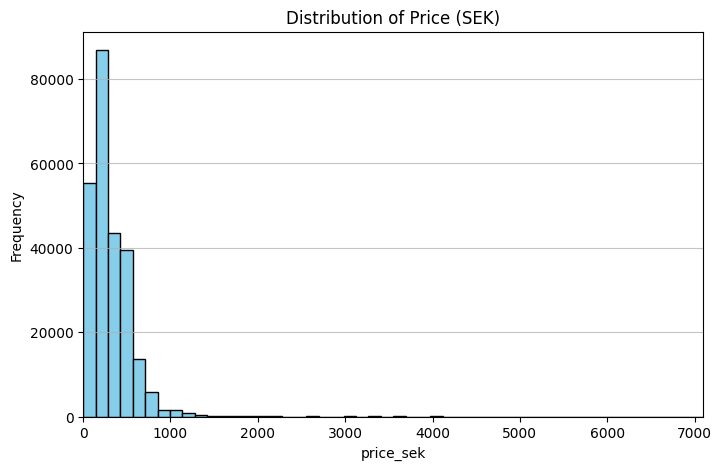

In [21]:
import matplotlib.pyplot as plt

# Show key statistics in numbers
price_sek = tx["price_sek"].dropna()
print("Price (SEK) statistics:")
print(f"  Count: {price_sek.count():,}")
print(f"  Mean: {price_sek.mean():,.2f}")
print(f"  Median: {price_sek.median():,.2f}")
print(f"  Std: {price_sek.std():,.2f}")
print(f"  Min: {price_sek.min():,.2f}")
print(f"  Max: {price_sek.max():,.2f}")

plt.figure(figsize=(8, 5))
plt.hist(
    price_sek, 
    bins=50, 
    color="skyblue", 
    edgecolor="black"
)
plt.title("Distribution of Price (SEK)")
plt.xlabel("price_sek")
plt.ylabel("Frequency")
plt.xlim(price_sek.min(), price_sek.max())
plt.grid(axis='y', alpha=0.75)
plt.show()


In [24]:
# Merge age info from customers into transactions
customers = pd.read_csv("../data/processed/customers_clean.csv", dtype={"shopUserId": str})
tx['shopUserId'] = tx['shopUserId'].astype(str)
tx = tx.merge(customers[['shopUserId', 'Age']], on='shopUserId', how='left')

In [25]:
tx.isna().mean()

orderId             0.000000
shopUserId          0.000000
created             0.000000
currencyId          0.000000
orderLineId         0.000000
sku                 0.000000
quantity            0.000000
price               0.000000
name                0.000000
status              0.000000
groupId             0.000000
currency_country    0.000000
sek_rate            0.000000
price_sek           0.000000
Age                 0.503653
dtype: float64

In [32]:
# Save cleaned transactions to CSV
tx.to_csv("../data/processed/transactions_clean.csv", index=False)

In [33]:
# Remove rows where Age is less than 20 or more than 100
tx = tx[~((tx['Age'] < 20) | (tx['Age'] > 100))]


In [34]:
print("Age column statistics:")
print(f"  Count: {tx['Age'].count():,}")
print(f"  Mean: {tx['Age'].mean():.2f}")
print(f"  Median: {tx['Age'].median():.2f}")
print(f"  Std: {tx['Age'].std():.2f}")
print(f"  Min: {tx['Age'].min():.2f}")
print(f"  Max: {tx['Age'].max():.2f}")

Age column statistics:
  Count: 124,051
  Mean: 74.26
  Median: 76.00
  Std: 11.62
  Min: 20.00
  Max: 100.00


In [43]:
# aggregate rows based on orderId (object dtypes OK, in-place edits)

import pandas as pd
import numpy as np

# --- Parse numerics & time from object ---
tx.loc[:, 'created']  = pd.to_datetime(tx['created'], errors='coerce')
tx.loc[:, 'quantity'] = pd.to_numeric(tx['quantity'], errors='coerce').fillna(1).clip(lower=1).round().astype('Int64')
tx.loc[:, 'price_sek']    = pd.to_numeric(tx['price'], errors='coerce').round().astype('Int64')

# Line total (no decimals)
tx.loc[:, '_line_total'] = (tx['price'] * tx['quantity']).round().astype('Int64')

# --- One row per orderId ---
orders = (
    tx.sort_values(['orderId','created'])
      .groupby('orderId', as_index=False)
      .agg(
          shopUserId    = ('shopUserId','first'),
          order_created = ('created','min'),
          total_qty     = ('quantity','sum'),
          basket_value  = ('_line_total','sum'),
          currencyId    = ('currencyId','first')
      )
)

# Ensure basket_value and total_qty are integers (no decimals)
orders['total_qty'] = orders['total_qty'].astype(int)
orders['basket_value'] = orders['basket_value'].astype(int)
orders['avg_unit_price'] = (orders['basket_value'] / orders['total_qty']).round().astype(int)

# SKUs per order (unique, sorted) — stays object list
sku_list = (
    tx.groupby('orderId')['sku']
      .apply(lambda s: sorted(pd.Series(s, dtype='string').dropna().unique().tolist()))
      .rename('sku_list')
)

# Group IDs per order (unique, sorted) — stays object list
groupid_list = (
    tx.groupby('orderId')['groupId']
      .apply(lambda s: sorted(pd.Series(s, dtype='string').dropna().unique().tolist()))
      .rename('groupid_list')
)

orders = orders.merge(sku_list, on='orderId', how='left')
orders = orders.merge(groupid_list, on='orderId', how='left')

print(orders.head(10).to_string(index=False))


 orderId shopUserId       order_created  total_qty  basket_value  currencyId  avg_unit_price                                sku_list             groupid_list
  158790      78135 2024-05-22 12:38:29          1            11          50              11                                [291294]                 [291294]
  158791      78136 2024-05-22 12:44:01          1            89          40              89                                [542092]                 [542087]
  158800      78145 2024-05-22 12:54:51          2           308          40             154                   [250209-0039, 261518]         [250209, 261518]
  158805      78150 2024-05-22 12:59:31          3          1075         134             358           [200226, 250116-0042, 542252] [200226, 250116, 542251]
  158808      78150 2024-05-22 13:07:10          1           418         134             418                           [270482-4446]                 [270482]
  158817      78162 2024-05-22 13:23:46          1  

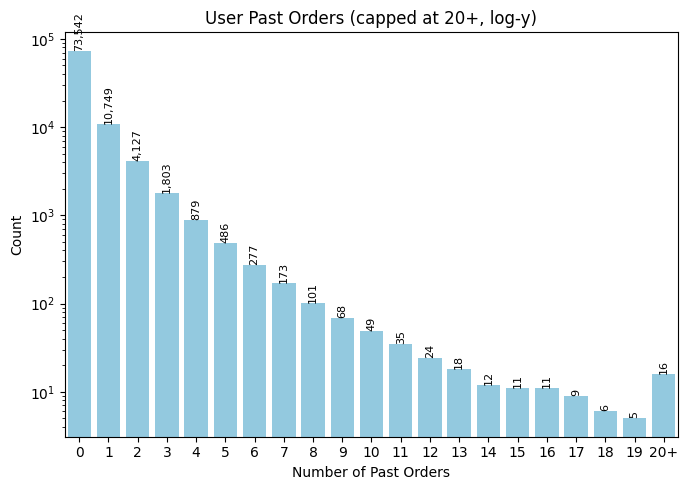

In [36]:
# Plot 1: Past orders 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

o = orders.sort_values(['shopUserId','order_created','orderId'])
past = o.groupby('shopUserId').cumcount().astype('Int32')           # 0,1,2,...
past_cap = past.clip(upper=20)

bins   = list(range(0, 21)) + [np.inf]
labels = [str(i) for i in range(0, 20)] + ['20+']
past_cat = pd.cut(past_cap, bins=bins, right=False, labels=labels, include_lowest=True)

plt.figure(figsize=(7,5))
ax = sns.countplot(x=past_cat, color='skyblue')
ax.set_yscale('log')
ax.set_title('User Past Orders (capped at 20+, log-y)')
ax.set_xlabel('Number of Past Orders'); ax.set_ylabel('Count')

for p in ax.patches:
    h = int(p.get_height())
    if h > 0:
        ax.annotate(f'{h:,}', (p.get_x()+p.get_width()/2., h),
                    ha='center', va='bottom', fontsize=8, rotation=90)

plt.tight_layout(); plt.show()


In [37]:
# Customers who ordered once vs. more than once, and more than twice
order_counts = orders.groupby('shopUserId')['orderId'].nunique()

one_time_customers   = int((order_counts == 1).sum())
repeat_customers     = int((order_counts > 1).sum())
more_than_two_customers = int((order_counts > 2).sum())
total_customers      = int(order_counts.size)

print(f"One-time customers:      {one_time_customers:,} ({one_time_customers/total_customers*100:.1f}%)")
print(f"Repeat customers:        {repeat_customers:,} ({repeat_customers/total_customers*100:.1f}%)")
print(f"More than 2 orders:      {more_than_two_customers:,} ({more_than_two_customers/total_customers*100:.1f}%)")


One-time customers:      62,793 (85.4%)
Repeat customers:        10,749 (14.6%)
More than 2 orders:      4,127 (5.6%)


In [ ]:
# Aggregate order lines to order-level summary with groupid_list per order

# First, ensure order_created is datetime
orders['order_created'] = pd.to_datetime(orders['order_created'], errors='coerce')

# Helper to extract groupId prefix (before dash) as in your example
def groupid_prefix(x):
    # Handles both int and str, e.g. 250209-0039 -> 250209, 542092 -> 542092
    return [str(i).split('-')[0] for i in x]

# Group by orderId, shopUserId, order_created, currencyId
order_agg = (
    orders
    .sort_values(['orderId', 'orderLineId' if 'orderLineId' in orders.columns else 'sku'])  # stable order for lists
    .groupby(['orderId', 'shopUserId', 'order_created', 'currencyId'], as_index=False)
    .agg(
        total_qty=('quantity', 'sum'),
        basket_value=('price', 'sum'),
        sku_list=('sku', lambda x: list(x)),
        groupid_list=('sku', lambda x: groupid_prefix(x)),
        avg_unit_price=('price', lambda x: np.round(x.sum() / x.count(), 2))
    )
)

# Reorder columns for clarity
order_agg = order_agg[[
    'orderId', 'shopUserId', 'order_created', 'total_qty', 'basket_value', 'currencyId',
    'avg_unit_price', 'sku_list', 'groupid_list'
]]

# Show a sample
print(order_agg.head(10).to_string(index=False))


NameError: name 'order_agg' is not defined

Number of rebuys with valid time delta: 6615
Rebuy time (days) statistics:
count    6615.000000
mean       29.014609
std        67.606202
min         0.000000
10%         0.000000
25%         0.000000
50%         0.000000
75%        13.481667
90%       116.604544
99%       310.067378
max       413.186331
Name: rebuy_timedelta, dtype: float64


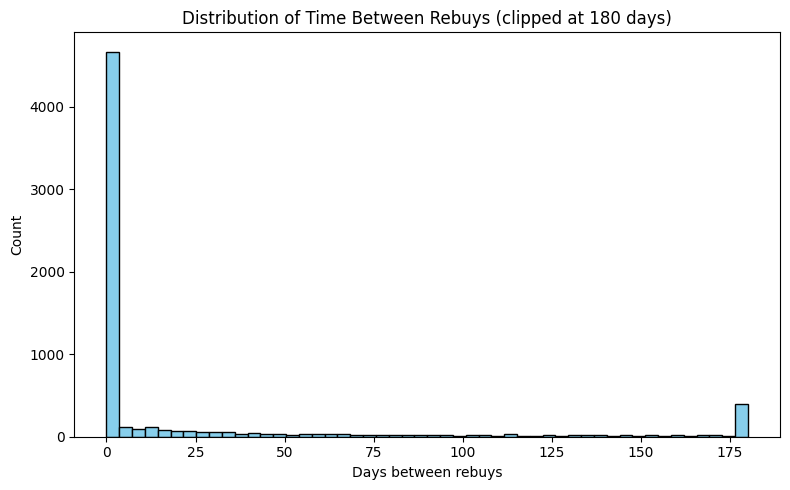

In [42]:
# Distribution of time between rebuys

# We'll use tx_sorted from above, which is sorted by user and time, and has is_rebuy and prev_groupId columns

# Only consider rows where a rebuy occurred (i.e., is_rebuy == True and prev_groupId is not null)
rebuy_rows = tx_sorted[rebuy_mask & tx_sorted['is_rebuy']].copy()

# Compute time difference between current and previous order
rebuy_rows['created'] = pd.to_datetime(rebuy_rows['created'], errors='coerce')
rebuy_rows['prev_created'] = rebuy_rows.groupby('shopUserId')['created'].shift(1)
rebuy_rows['rebuy_timedelta'] = rebuy_rows['created'] - rebuy_rows['prev_created']

# Drop any rows with missing time deltas (should be rare)
rebuy_time_deltas = rebuy_rows['rebuy_timedelta'].dropna()

# Convert to days for easier interpretation
rebuy_time_days = rebuy_time_deltas.dt.total_seconds() / (24*3600)

print(f"Number of rebuys with valid time delta: {rebuy_time_days.shape[0]}")

# Show basic statistics
print("Rebuy time (days) statistics:")
print(rebuy_time_days.describe(percentiles=[.1, .25, .5, .75, .9, .99]))

# Plot the distribution (clip at 180 days for visualization)
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.hist(rebuy_time_days.clip(upper=180), bins=50, color='skyblue', edgecolor='k')
plt.title("Distribution of Time Between Rebuys (clipped at 180 days)")
plt.xlabel("Days between rebuys")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


In [18]:
# Same-user, same-day orders (calendar day) and check if those orders have the same total price

import pandas as pd

# ensure datetime
orders['order_created'] = pd.to_datetime(orders['order_created'], errors='coerce')

# calendar day
orders['_order_date'] = orders['order_created'].dt.floor('D')

# aggregate per (user, day)
same_day = (orders
    .groupby(['shopUserId','_order_date'], as_index=False)
    .agg(
        n_orders=('orderId','nunique'),
        orderIds=('orderId', lambda s: sorted(s.tolist())),
        times=('order_created', lambda s: sorted(s.dt.strftime('%H:%M:%S').tolist())),
        basket_values=('basket_value', lambda s: sorted(s.tolist()))
    )
)

# keep only days with 2+ orders
same_day_multi = same_day.query('n_orders > 1').sort_values(['n_orders', '_order_date', 'shopUserId'], ascending=[False, True, True])

# Check if all basket_values are the same for each group
def all_equal(lst):
    return len(set(lst)) == 1 if len(lst) > 1 else True

same_day_multi['same_total_price'] = same_day_multi['basket_values'].apply(all_equal)

print(f"Users with multiple orders on the same day: {same_day_multi.shape[0]}")
print(same_day_multi[['shopUserId', '_order_date', 'n_orders', 'orderIds', 'times', 'basket_values', 'same_total_price']].head(10).to_string(index=False))


Users with multiple orders on the same day: 753
shopUserId _order_date  n_orders                                         orderIds                                                        times                        basket_values  same_total_price
    183783  2024-09-02         6 [284522, 284542, 284545, 284552, 284557, 284563] [12:32:27, 12:40:17, 12:41:25, 12:42:53, 12:44:51, 12:46:16]       [279, 298, 398, 458, 498, 498]             False
    654825  2025-05-21         6 [709594, 709601, 709604, 709654, 709670, 709682] [11:26:01, 11:26:48, 11:27:53, 11:30:05, 11:35:14, 11:40:26] [1274, 1274, 1274, 1274, 1274, 1274]              True
    703767  2025-04-16         5         [665013, 665017, 665025, 665029, 665045]           [17:33:15, 17:38:46, 17:43:46, 17:48:28, 18:01:02]            [139, 149, 278, 298, 298]             False
    262090  2024-06-24         4                 [192175, 192347, 192367, 192415]                     [09:38:27, 11:55:01, 12:06:48, 12:41:22]                 [